Lets tackle this strong enemy with art framework.

At first, we need to download the data. We highly recommend using huggingface datasets wrapped into Lighntning Data Module. But if you want you can use Torch Datasets and DataLoaders.

In [ ]:
!pip install transformers

In [8]:
%load_ext autoreload
%autoreload 2

import datasets
from art_data import MNISTDataModule
from art.enums import INPUT, TARGET
from art.step.checks import CheckScoreExists, CheckScoreEqualsTo, CheckScoreGreaterThan, CheckScoreLessThan
mnist_data = datasets.load_dataset("mnist")

mnist_data = mnist_data.rename_columns({"image": INPUT, "label": TARGET})
mnist_data['train'] = mnist_data['train'].select(range(6000))
#mnist_data['test'] = mnist_data['test'].select(range(16))

mnist_data_module = MNISTDataModule(mnist_data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Found cached dataset mnist (/home/kacper/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

#### Data analysis

TBD

#### Baselines

Starting any Machine Learning project it is good to have some baseline for comparison. Here in `ART` we try to encourage you to try at least one of those:
* Ml Baseline - Not for all problems we need Deep Learninr. For tabular data or timeseries there are ML models that you can take off the shelf and obtain very good results. 
* Heuristic Baseline - Sometimes you may have some intuition on how should be data regressed or classified. It is always worth to check how good these are.
* existing solution baseline - If problem is already solved, checking existing solutions and pointing their drawback to improve on is always worth doing.


Another good habbit is to separate your code into many smaller modules, and don't do everything inside one gigantic jupyter notebook. Look inside `baselines.py` file where we have prepared everything for you.

Have you observed plenty of small functions inside each of the class? These will create pipelines of your ArtModule.

e.g `MlBaseline` has functions `parse_data_for_ml` and `baseline_train` that both creates `ml_train_pipeline` that is defined inside art. As you become more familar with `ART` you will be able to create your own pipelines and it's building blocks.

Finally to offer you high level of flexibility we pass data between all stages with use of a dictionary (This will be changed into some better structure in the future).

In [9]:
from baselines import MlBaseline, HeuristicBaseline, AlreadyExistingSolutionBaseline
from sklearn.linear_model import LogisticRegression
from art.metric_calculator import MetricCalculator
from torchmetrics import Accuracy
import torch.nn as nn
from art.step.steps import EvaluateBaselines


MetricCalculator.register_metric(Accuracy(task="multiclass", num_classes = 10))
MetricCalculator.register_metric(nn.CrossEntropyLoss(), exception_steps = [EvaluateBaselines])

TODO Describe metric calculator

In [14]:
from art.experiment.Experiment import Experiment
exp = Experiment("exp1")
baselines = [HeuristicBaseline(), MlBaseline(model = LogisticRegression()), AlreadyExistingSolutionBaseline()]
baseline_names = [baseline.name for baseline in baselines]
exp.add_step(
    EvaluateBaselines(
        baselines, mnist_data_module
    ), [CheckScoreExists('Evaluate Baselines', f"check_{name}", name) for name in baseline_names]
)

In [15]:
#TODO there is a lot of prompt here, discuss if we want tu surpress it
# One solution is logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING) etc.
exp.run_all()

Evaluate Baselines


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audi

Validation: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Having baselines we can move on to beating them. We will use CNN for this purpose that is defined inside `models.py`

In [ ]:
from models import MNISTModel
from art.step.steps import CheckLossOnInit
MetricCalculator.to("cuda")
my_model = MNISTModel()

exp = Experiment("exp1") # TODO This should be removed
exp.add_step(CheckLossOnInit(my_model, mnist_data_module), [])
exp.run_all() # TODO Now evaluate baselines shouldn't be run.p
# TODO some kind of exception or indication of not passed stage should be shown.

We have 10 classes, so on average with random initialization loss should be -log(1/10) = 2.31, something must be wrong in our pipeline. Lets discover another feature of art that helps you to debug the code. 

In [6]:
import lovely_tensors as lt
from art.visualization_decorators import set_visualization
lt.monkey_patch()


set_visualization([(my_model, "predict")], print)
exp.run_all() # Now evaluate baselines shouldn't be run.p

You may decorate any function in your pipeline with some any logging function. Here it is simple print, but in practice you can do much, much more, which you will see later. Can you spot what is wrong? Yes we do not normalize images to [0,1] range. Change the 26 line in `baselines.py`


Let's move further. We have already found some issues. Next step is to overfit just single batch. If you can't do this there is for sure something wrong

In [7]:
from models import MNISTModel
from art.step.steps import OverfitOneBatch
exp = Experiment("exp1") # TODO THIS SHOULDN'T BE NECESSARY
exp.add_step(OverfitOneBatch(MNISTModel(), mnist_data_module), [])
exp.run_all() # Now evaluate baselines shouldn't be run.p

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Overfit One Batch


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


{'MulticlassAccuracy-MNISTModel-VALIDATION-Overfit One Batch': tensor 0.438, 'CrossEntropyLoss-MNISTModel-VALIDATION-Overfit One Batch': tensor 1.853}
Loss at the end of overfitting: 1.853304386138916


Oh no... again we can't overfit. It this an issue with model? Maybe but at first let's see another powerful usecase of art. We will debug the prediction dynamics too see how our model is evolving. We will calculate average logit value for all images that should be classified as 0

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Overfit One Batch


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


{'MulticlassAccuracy-MNISTModel-VALIDATION-Overfit One Batch': tensor 0.438, 'CrossEntropyLoss-MNISTModel-VALIDATION-Overfit One Batch': tensor 1.938}
Loss at the end of overfitting: 1.938249111175537


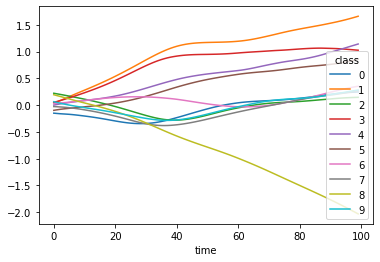

In [9]:
class EvolutionSaver:
    def __init__(self):
        self.logits = []
        self.time = 0

    def __call__(self, data):
        targets = data['target'] == 1
        logits = data['prediction']

        wanted_logits = logits[targets].mean(dim=0)
        for i, logit in enumerate(wanted_logits):
            self.logits.append({
                "time": self.time,
                "logit": logit.item(),
                "class": i
            })

        self.time += 1    

    def visualize(self):
        import pandas as pd
        import matplotlib.pyplot as plt
        df = pd.DataFrame(self.logits)
        df = df.pivot(index='time', columns='class', values='logit')
        df.plot()
        plt.show()

exp = Experiment("exp1") # TODO THIS SHOULDN'T BE NECESSARY
my_model = MNISTModel()
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver)
exp.add_step(OverfitOneBatch(my_model, mnist_data_module), [])
exp.run_all()
evolution_saver.visualize()

So, as you can see we move in correct direction - Probably we should just wait a little bit longer. Moreover, we see how powerful decorators can be. This helps us make our code more modular and fulfill Open-Closed principle.

We can solve our problem in two ways:
* Either increase learning rate.
* Or train for longer.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Overfit One Batch


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


{'MulticlassAccuracy-MNISTModel-VALIDATION-Overfit One Batch': tensor 1.000, 'CrossEntropyLoss-MNISTModel-VALIDATION-Overfit One Batch': tensor 0.074}
Loss at the end of overfitting: 0.07376985996961594


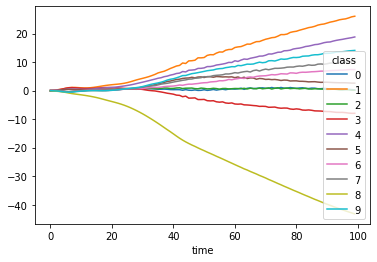

In [10]:
exp = Experiment("exp1") # TODO THIS SHOULDN'T BE NECESSARY
my_model = MNISTModel(lr=0.01)
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver)
exp.add_step(OverfitOneBatch(my_model, mnist_data_module), [])
exp.run_all()
evolution_saver.visualize()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Overfit One Batch


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


{'MulticlassAccuracy-MNISTModel-VALIDATION-Overfit One Batch': tensor 1.000, 'CrossEntropyLoss-MNISTModel-VALIDATION-Overfit One Batch': tensor 0.026}
Loss at the end of overfitting: 0.02627135068178177


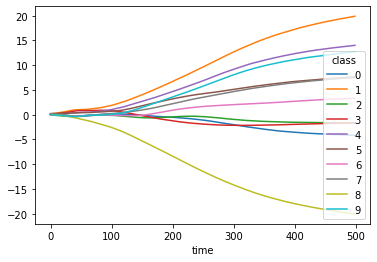

In [11]:
exp = Experiment("exp1") # TODO THIS SHOULDN'T BE NECESSARY
my_model = MNISTModel()
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver)
exp.add_step(OverfitOneBatch(my_model, mnist_data_module, number_of_steps=500), [])
exp.run_all()
evolution_saver.visualize()

But for the very beginning of the training process we'd recommend not to play with learning rate and stick with default value. It is better to just wait for a little bit longer. Now another Step can be taken. Overfitting entire training set. This is also very important as this somehow approximates our best possible score that can be achieved. If it is much below our expected result this again may indicate problems.

In [12]:
from art.step.steps import Overfit
exp = Experiment("exp1") # TODO THIS SHOULDN'T BE NECESSARY
my_model = MNISTModel()
exp.add_step(Overfit(my_model, mnist_data_module, max_epochs=50), [])
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Overfit


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Validate metric                  ┃                   DataLoader 0                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-VALIDATION-Overfit  │               0.34472474455833435                │
│ MulticlassAccuracy-MNISTModel-VALIDATION-Overfit │                0.9006666541099548                │
└──────────────────────────────────────────────────┴──────────────────────────────────────────────────┘

KeyError: 'validation_loss'

In [46]:
from art.experiment_state import ExperimentState

In [49]:
ExperimentState.current_step